In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pydicom

In [2]:
# Training and testing data
train_input_data = ['Noisy Images/1-1_speckle_noise.png', 'Noisy Images/1-2_speckle_noise.png']
test_input_data = ['Noisy Images/1-6_speckle_noise.png']
train_output_data = ['Photos/1-1.dcm', 'Photos/1-2.dcm']
test_output_data = ['Photos/1-6.dcm']

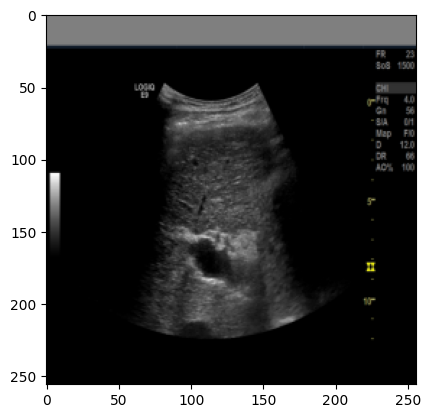

In [3]:
from skimage.transform import resize

dicom_file = pydicom.dcmread('Photos/1-1.dcm')
image_array = dicom_file.pixel_array

normalized_pixel_array = image_array / np.max(image_array)

new_size = (256, 256)
resized_image = resize(normalized_pixel_array, new_size, anti_aliasing=True)

plt.imshow(resized_image, cmap='gray')

In [4]:
# convert image to tensor
image_tensor = torch.tensor(resized_image)
image_tensor = image_tensor.unsqueeze(0)

In [5]:
print(image_tensor.shape)

torch.Size([1, 256, 256, 3])


In [6]:
import torchvision.models as models
import torch.nn as nn

class DenoisingResNet(nn.Module):
    def __init__(self):
        super(DenoisingResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(256, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 256 * 256 * 3)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(-1, 256, 256, 3)
        return x

model = DenoisingResNet()


/Users/herdt/Library/CloudStorage/OneDrive-UniversityofIowa/Year 4/Sem 1/Deep Learning in Medicla Imaging/ImageResolutionEnhancement/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/herdt/Library/CloudStorage/OneDrive-UniversityofIowa/Year 4/Sem 1/Deep Learning in Medicla Imaging/ImageResolutionEnhancement/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
# Train the model
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert image_tensor to float32
image_tensor = image_tensor.float()

for epoch in range(100):
    optimizer.zero_grad()
    output = model(image_tensor)
    loss = criterion(output, image_tensor)
    loss.backward()
    optimizer.step()
    print('Epoch:', epoch, 'Loss:', loss.item())

Epoch: 0 Loss: 0.28614160418510437
Epoch: 1 Loss: 0.1047685518860817
Epoch: 2 Loss: 0.059328947216272354
Epoch: 3 Loss: 0.06285839527845383
Epoch: 4 Loss: 0.07602604478597641
Epoch: 5 Loss: 0.06386692076921463
Epoch: 6 Loss: 0.04552406445145607
Epoch: 7 Loss: 0.032449960708618164
Epoch: 8 Loss: 0.02553318440914154
Epoch: 9 Loss: 0.022053098306059837
Epoch: 10 Loss: 0.0197353046387434
Epoch: 11 Loss: 0.017759384587407112
Epoch: 12 Loss: 0.015654245391488075
Epoch: 13 Loss: 0.013396445661783218
Epoch: 14 Loss: 0.011278853751718998
Epoch: 15 Loss: 0.009505475871264935
Epoch: 16 Loss: 0.008145134896039963
Epoch: 17 Loss: 0.007107935380190611
Epoch: 18 Loss: 0.006336421240121126
Epoch: 19 Loss: 0.005737441126257181
Epoch: 20 Loss: 0.005226418375968933
Epoch: 21 Loss: 0.0047498238272964954
Epoch: 22 Loss: 0.004275302868336439
Epoch: 23 Loss: 0.0038119431119412184
Epoch: 24 Loss: 0.0033756971824914217
Epoch: 25 Loss: 0.0029808685649186373
Epoch: 26 Loss: 0.002637471305206418
Epoch: 27 Loss: 0

In [8]:
# Test the model
image_file = Image.open('Noisy Images/1-2_speckle_noise.png')
image_array = np.array(image_file)

normalized_pixel_array = image_array / np.max(image_array)

new_size = (256, 256)
resized_image = resize(normalized_pixel_array, new_size, anti_aliasing=True)

# Convert image to tensor
test_image_tensor = torch.tensor(resized_image).unsqueeze(0).float()

# Pass the tensor through the model
with torch.no_grad():
	output = model(test_image_tensor)

# Display the output image
output_image = output.squeeze().numpy()
plt.imshow(output_image, cmap='gray')

RuntimeError: Given groups=1, weight of size [64, 256, 7, 7], expected input[1, 1, 256, 256] to have 256 channels, but got 1 channels instead

In [ ]:
# Create a GAN model for denoising
class DenoisingGAN(nn.Module):
    def __init__(self):
        super(DenoisingGAN, self).__init__()
        self.generator = DenoisingResNet()
        self.discriminator = models.resnet18(pretrained=False)
        self.discriminator.conv1 = nn.Conv2d(256, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.discriminator.fc = nn.Linear(self.discriminator.fc.in_features, 1)

    def forward(self, x):
        x = self.generator(x)
        x = self.discriminator(x)
        return x
    
gan_model = DenoisingGAN()

In [ ]:
# train the GAN model
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(gan_model.parameters(), lr=0.001)

for epoch in range(100):
    optimizer.zero_grad()
    output = gan_model(image_tensor)
    loss = criterion(output, torch.ones_like(output))
    loss.backward()
    optimizer.step()
    print('Epoch:', epoch, 'Loss:', loss.item())


Epoch: 0 Loss: 0.42576438188552856
Epoch: 1 Loss: 0.33729711174964905
Epoch: 2 Loss: 0.12680864334106445
Epoch: 3 Loss: 0.025442123413085938
Epoch: 4 Loss: 0.010843034833669662
Epoch: 5 Loss: 0.005799239035695791
Epoch: 6 Loss: 0.0035921535454690456
Epoch: 7 Loss: 0.0024368565063923597
Epoch: 8 Loss: 0.0017618021229282022
Epoch: 9 Loss: 0.0013344098115339875
Epoch: 10 Loss: 0.0010439082980155945
Epoch: 11 Loss: 0.0008406318374909461
Epoch: 12 Loss: 0.0006944658234715462
Epoch: 13 Loss: 0.0005845937412232161
Epoch: 14 Loss: 0.0005009055021218956
Epoch: 15 Loss: 0.00043591600842773914
Epoch: 16 Loss: 0.0003841482975985855
Epoch: 17 Loss: 0.00034235251951031387
Epoch: 18 Loss: 0.00030823482666164637
Epoch: 19 Loss: 0.00028001866303384304
Epoch: 20 Loss: 0.00025652037584222853
Epoch: 21 Loss: 0.00023671810049563646
Epoch: 22 Loss: 0.00021988089429214597
Epoch: 23 Loss: 0.0002054355718428269
Epoch: 24 Loss: 0.00019295528181828558
Epoch: 25 Loss: 0.00018214911688119173
Epoch: 26 Loss: 0.0001

KeyboardInterrupt: 